In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS
import warnings
import pickle as pkl

warnings.filterwarnings('ignore')

# Alphas

In [2]:
rets = pd.read_csv('returns_spx_v11.csv', index_col=0, parse_dates=True)
rets = rets.rename(columns={
    'Daily_Return': 'rets'
})

Text(0, 0.5, 'Cumulative alpha')

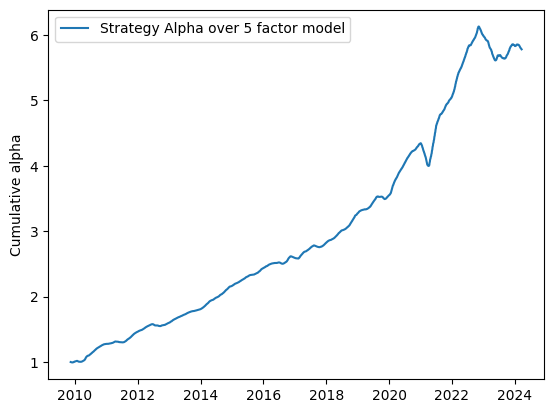

In [44]:
YEAR = 252
with open('alphas.pkl','rb') as f:
    alphas = pkl.load(f)
alphas = pd.Series(alphas)
new_alphas = rets.copy()
new_alphas = new_alphas.iloc[-len(alphas):]
for i in range(len(alphas)):
    new_alphas.iloc[i] = alphas.iloc[i]
new_alphas = new_alphas.reset_index()

fig, ax1 = plt.subplots()
ax1.plot(new_alphas['Date'], (1+new_alphas['rets']).cumprod())
ax1.legend(['Strategy Alpha over 5 factor model'])#, loc='upper center')
ax1.set_ylabel('Cumulative alpha')

# Company data

Ratios
- MKTVal: daily_prices[resample].market_cap
- BTM: ratios.book_value_per_share / daily_prices[resample].price
- PER: ratios.per
- EVEBIT: ratios.EV_EBIT
- EVEBITDA: ratios.EV_EBITDA
- GPA: (income_statement.sales - income_statement.COGS_incl_depreciation_and_amortization)/ balance_sheet.total_assets
- ROC: income_statement.consolidated_net_income / (daily_prices[resample].market_cap + balance_sheet.total_liabilities)
- ROCD: NO
- MOM: NO

(listing.common_shares_outstanding * daily_prices[resample].price + balance_sheet.total_liabilities - balance_sheet.cash_and_short-term_investments)

In [21]:
bs = pd.read_excel('20240529/balance_sheet.xlsx', index_col=0)
bs = bs[['id', 'date', 'total_assets', 'total_liabilities']]
ratios = pd.read_excel('20240529/ratios.xlsx', index_col=0)
ratios = ratios[['id','date','EV_EBIT','EV_EBITDA','PER','book_value_per_share']]
istatement = pd.read_excel('20240529/income_statement.xlsx', index_col=0)
istatement = istatement[['id','date','sales','COGS_incl_depreciation_and_amortization','consolidated_net_income']]
dprices = pd.read_csv('20240529/daily_prices.csv', index_col=0)
dprices = dprices[['id', 'date', 'price', 'market_cap']]
dprices['date'] = pd.to_datetime(dprices['date'])
symbols = pd.read_excel('20240529/listing.xlsx', index_col=0)
symbols = symbols.reset_index()
symbols = symbols[['id','symbol']]
comp_data = bs.merge(ratios,on=['id','date'], how='outer').merge(istatement,on=['id','date'], how='outer').merge(dprices,on=['id','date'], how='left').merge(symbols,on='id')

In [22]:
comp_data['MKTVal'] = comp_data['market_cap']
comp_data['BTM'] = comp_data['book_value_per_share']/comp_data['market_cap']
comp_data = comp_data.rename(columns={
    'per': 'PER',
    'EV_EBIT': 'EVEBIT',
    'EV_EBITDA': 'EVEBITDA',
})
comp_data['GPA'] = (comp_data['sales'] - comp_data['COGS_incl_depreciation_and_amortization'])/comp_data['total_assets']
comp_data['ROC'] = comp_data['consolidated_net_income']/(comp_data['market_cap']+comp_data['total_liabilities'])
comp_data = comp_data[['symbol','date','MKTVal','BTM','PER','EVEBIT','EVEBITDA','GPA','ROC']]
comp_data = comp_data.dropna()
comp_data.head()

,symbol,date,MKTVal,BTM,PER,EVEBIT,EVEBITDA,GPA,ROC
0,CTAS-US,2000-02-29,4455.627285,0.000912,31.445613,20.806898,15.422970,0.109155,0.009853
1,CTAS-US,2000-05-31,7368.151672,0.000841,42.173871,23.603222,17.973103,0.179737,0.006681
2,CTAS-US,2000-08-31,6994.220529,0.000927,38.130734,21.783378,16.567271,0.118323,0.006775
3,CTAS-US,2000-11-30,8571.864257,0.000795,44.946175,25.693125,19.683134,0.117704,0.006218
4,CTAS-US,2001-02-28,6077.888964,0.001175,28.583833,17.858309,13.683863,0.110905,0.008325


In [39]:
comp_data = comp_data.sort_values(by='date',ascending=True)
new_alphas = new_alphas.reset_index().sort_values(by='Date',ascending=True).set_index('Date')
if comp_data['date'].min() < new_alphas.index.min():
    f_comp_data = comp_data[comp_data['date'] >= new_alphas.index.min()]
    f_new_alphas = new_alphas.copy()
else:
    f_new_alphas = new_alphas[new_alphas.index >= comp_data['date'].min()]
    f_comp_data = comp_data.copy()

if f_comp_data['date'].max() > f_new_alphas.index.max():
    f_comp_data = f_comp_data[f_comp_data['date'] <= f_new_alphas.index.max()]
    f_new_alphas = f_new_alphas.copy()
else:
    f_new_alphas = f_new_alphas[f_new_alphas.index <= f_comp_data['date'].max()]
    f_comp_data = f_comp_data.copy()

data = {
    'date':[],
    'cumalpha':[],
}
f_comp_data_dates = pd.unique(f_comp_data['date'])
for i in range(1,len(f_comp_data_dates)):
    a = f_new_alphas[(f_new_alphas.index>f_comp_data_dates[i-1])&(f_new_alphas.index<=f_comp_data_dates[i])]
    a = (1+a).cumprod() - 1
    data['date'].append(f_comp_data_dates[i])
    data['cumalpha'].append(a.iloc[-1,0])
alphas_reshaped = pd.DataFrame(data)
alphas_reshaped['date'] = pd.to_datetime(alphas_reshaped['date'])
alphas_reshaped = alphas_reshaped.iloc[1:,:]
comb_data = f_comp_data.merge(alphas_reshaped, left_on='date',right_on='date',how='inner')
comb_data.head()

,symbol,date,MKTVal,BTM,PER,EVEBIT,EVEBITDA,GPA,ROC,cumalpha
0,DG-US,2010-01-29,8000.412340,0.001244,23.063328,11.697775,9.225695,0.115686,0.006481,0.007211
1,TJX-US,2010-01-29,15953.138952,0.000111,13.336842,7.515997,6.164785,0.211608,0.019242,0.007211
2,BF.B-US,2010-01-29,7737.362450,0.000442,16.771243,11.017629,10.202691,0.121727,0.011624,0.007211
3,DE-US,2010-01-29,21110.268459,0.000556,23.341121,13.645879,10.499364,0.036674,0.004272,0.007211
4,CSCO-US,2010-01-29,129260.580122,0.000056,22.086538,14.242944,11.540796,0.082601,0.011290,0.007211


# Factor regression

In [40]:
comb_data['symbol'] = comb_data['symbol'].astype('category')
comb_data = comb_data.set_index(['symbol','date'])
Y = comb_data['cumalpha']
factors_list = list(set(comb_data.columns) - set(['cumalpha']))
X = comb_data[factors_list]
X = (X - X.min()) / (X.max() - X.min())
model = PanelOLS(Y, sm.tools.add_constant(X), entity_effects=True)
result = model.fit()
result

Dep. Variable:,cumalpha,R-squared:,0.0028
Estimator:,PanelOLS,R-squared (Between):,-0.7925
No. Observations:,21330,R-squared (Within):,0.0028
Date:,"Tue, Jun 25 2024",R-squared (Overall):,-0.0107
Time:,05:43:19,Log-likelihood,6.366e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,8.4817
Entities:,446,P-value,0.0000
Avg Obs:,47.825,Distribution:,"F(7,20877)"
Min Obs:,1.0000,,
Max Obs:,57.000,F-statistic (robust):,8.4817


## Full Regression - Strategy Long

In [9]:
factors['mkt-rf'] = factors['mkt-rf'].astype(np.float32)
factors['smb'] = factors['smb'].astype(np.float32)
factors['hml'] = factors['hml'].astype(np.float32)
factors['mom'] = factors['mom'].astype(np.float32)
rets_long['rets'] = rets_long['rets'].astype(np.float32)
risk_free['rf'] = risk_free['rf'].astype(np.float32)
vol_spread['vol_spread'] = vol_spread['vol_spread'].astype(np.float32)
melted_market_spread_over_sp['stock'] = melted_market_spread_over_sp['stock'].astype('category')
melted_market_spread_over_sp['spread_over_sp'] = melted_market_spread_over_sp['spread_over_sp'].astype(np.float32)
melted_vol_premium['stock'] = melted_vol_premium['stock'].astype('category')
melted_vol_premium['vol_premium'] = melted_vol_premium['vol_premium'].astype(np.float32)

full_dataset = rets_long.merge(factors, left_index=True, right_index=True, how='inner')
full_dataset = full_dataset.merge(risk_free, left_index=True, right_index=True, how='inner')
full_dataset = full_dataset.merge(vol_spread, left_index=True, right_index=True, how='inner')
full_dataset = full_dataset.merge(melted_market_spread_over_sp, left_index=True, right_on='Date', how='left')
full_dataset = full_dataset.merge(melted_vol_premium, left_on=['Date', 'stock'], right_on=['Date', 'stock'], how='left')
full_dataset['exc_rets'] = full_dataset['rets'] - full_dataset['rf']
full_dataset.index = full_dataset['Date']
full_dataset = full_dataset.drop(['Date'], axis=1)
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.reset_index()
full_dataset = full_dataset.set_index(['stock', 'Date'])

Y = full_dataset['exc_rets']
factors_list = list(set(full_dataset.columns) - set(['rets','exc_rets','rf']))
X = full_dataset[factors_list]
model = PanelOLS(Y, sm.tools.add_constant(X), entity_effects=True)
result = model.fit()
result

Dep. Variable:,exc_rets,R-squared:,0.0224
Estimator:,PanelOLS,R-squared (Between):,-1.729e+29
No. Observations:,1447462,R-squared (Within):,0.0224
Date:,"Thu, Jun 06 2024",R-squared (Overall):,0.0224
Time:,09:40:46,Log-likelihood,5.08e+06
Cov. Estimator:,Unadjusted,,
,,F-statistic:,4735.4
Entities:,397,P-value,0.0000
Avg Obs:,3646.0,Distribution:,"F(7,1447058)"
Min Obs:,3646.0,,
Max Obs:,3646.0,F-statistic (robust):,4735.4


## Full Regression - Strategy Short

In [11]:
factors['mkt-rf'] = factors['mkt-rf'].astype(np.float32)
factors['smb'] = factors['smb'].astype(np.float32)
factors['hml'] = factors['hml'].astype(np.float32)
factors['mom'] = factors['mom'].astype(np.float32)
rets_short['rets'] = rets_short['rets'].astype(np.float32)
risk_free['rf'] = risk_free['rf'].astype(np.float32)
vol_spread['vol_spread'] = vol_spread['vol_spread'].astype(np.float32)
melted_market_spread_over_sp['stock'] = melted_market_spread_over_sp['stock'].astype('category')
melted_market_spread_over_sp['spread_over_sp'] = melted_market_spread_over_sp['spread_over_sp'].astype(np.float32)
melted_vol_premium['stock'] = melted_vol_premium['stock'].astype('category')
melted_vol_premium['vol_premium'] = melted_vol_premium['vol_premium'].astype(np.float32)

full_dataset = rets_short.merge(factors, left_index=True, right_index=True, how='inner')
full_dataset = full_dataset.merge(risk_free, left_index=True, right_index=True, how='inner')
full_dataset = full_dataset.merge(vol_spread, left_index=True, right_index=True, how='inner')
full_dataset = full_dataset.merge(melted_market_spread_over_sp, left_index=True, right_on='Date', how='left')
full_dataset = full_dataset.merge(melted_vol_premium, left_on=['Date', 'stock'], right_on=['Date', 'stock'], how='left')
full_dataset['exc_rets'] = full_dataset['rets'] - full_dataset['rf']
full_dataset.index = full_dataset['Date']
full_dataset = full_dataset.drop(['Date'], axis=1)
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.reset_index()
full_dataset = full_dataset.set_index(['stock', 'Date'])

Y = full_dataset['exc_rets']
factors_list = list(set(full_dataset.columns) - set(['rets','exc_rets','rf']))
X = full_dataset[factors_list]
model = PanelOLS(Y, sm.tools.add_constant(X), entity_effects=True)
result = model.fit()
result

Dep. Variable:,exc_rets,R-squared:,0.0271
Estimator:,PanelOLS,R-squared (Between):,0.0000
No. Observations:,1447462,R-squared (Within):,0.0271
Date:,"Thu, Jun 06 2024",R-squared (Overall):,0.0270
Time:,09:39:31,Log-likelihood,6.045e+06
Cov. Estimator:,Unadjusted,,
,,F-statistic:,5751.4
Entities:,397,P-value,0.0000
Avg Obs:,3646.0,Distribution:,"F(7,1447058)"
Min Obs:,3646.0,,
Max Obs:,3646.0,F-statistic (robust):,5751.4


## Volatility Premium as Spread over SP regression

In [ ]:
melted_market_spread_over_sp['stock'] = melted_market_spread_over_sp['stock'].astype('category')
melted_market_spread_over_sp['spread_over_sp'] = melted_market_spread_over_sp['spread_over_sp'].astype(np.float32)
melted_vol_premium['stock'] = melted_vol_premium['stock'].astype('category')
melted_vol_premium['vol_premium'] = melted_vol_premium['vol_premium'].astype(np.float32)

full_dataset = melted_market_spread_over_sp.merge(melted_vol_premium, left_on=['Date', 'stock'], right_on=['Date', 'stock'], how='left')
full_dataset = full_dataset.dropna()
full_dataset = full_dataset.set_index(['stock', 'Date'])

Y = full_dataset['vol_premium']
factors_list = list(set(full_dataset.columns) - set(['vol_premium']))
X = full_dataset[factors_list]
model = PanelOLS(Y, sm.tools.add_constant(X), entity_effects=True)
result = model.fit()
result

Dep. Variable:,vol_premium,R-squared:,0.0954
Estimator:,PanelOLS,R-squared (Between):,-0.3695
No. Observations:,2035022,R-squared (Within):,0.0954
Date:,"Tue, Apr 02 2024",R-squared (Overall):,0.0706
Time:,17:47:34,Log-likelihood,-4.051e+05
Cov. Estimator:,Unadjusted,,
,,F-statistic:,2.145e+05
Entities:,397,P-value,0.0000
Avg Obs:,5126.0,Distribution:,"F(1,2034624)"
Min Obs:,5126.0,,
Max Obs:,5126.0,F-statistic (robust):,2.145e+05
